# Exercise 1 - Model Training and Evaluation

## a) Extracting TF-IDF features

Requirements:
- maximum numbers of terms set to 5000
- add idf smoothing for out-of-vocabulary words
- minimum number of documents a term must appear in as min_df=10
- maximum proportion of documents a term can appear in as max_df=0.9

In [7]:
# loading the dataset
import pandas as pd

# paths
train_csv = "../data/train.csv"
val_csv   = "../data/val.csv"
test_csv  = "../data/test.csv"

# load; all of them have 2 columns: Text, Label
train = pd.read_csv(train_csv)
val   = pd.read_csv(val_csv)
test  = pd.read_csv(test_csv)

print("Train:", train.shape, "Val:", val.shape, "Test:", test.shape)

Train: (50587, 2) Val: (6324, 2) Test: (6324, 2)


In [8]:
import spacy

# load Portuguese model
nlp = spacy.load("pt_core_news_lg")

# lemmatize a text using SpaCy
def lemmatize_text(text):
    doc = nlp(text)
    # join lemmas back into a string
    return " ".join([token.lemma_ for token in doc if not token.is_punct])

In [9]:
import re

# cleaning the dataset - lowercases and removes extra whitespaces in every text
def clean_data(text):
    #check for actual missing values
    if pd.isna(text) or text is None:
        return None
        
    #convert to string and strip whitespace
    text_str = str(text).lower().strip()
    
    #check for literal string "None", "nan", or empty
    if text_str in ['none', 'nan', 'null', '']:
        return None
    
    return text_str

# first clean
train['text_clean'] = train['Text'].apply(clean_data)
val['text_clean']   = val['Text'].apply(clean_data)
test['text_clean']  = test['Text'].apply(clean_data)

# drop nulls
train = train.dropna(subset=['text_clean']).reset_index(drop=True)
val   = val.dropna(subset=['text_clean']).reset_index(drop=True)
test  = test.dropna(subset=['text_clean']).reset_index(drop=True)

# then lemmatize
train['text_clean'] = train['text_clean'].apply(lemmatize_text)
val['text_clean']   = val['text_clean'].apply(lemmatize_text)
test['text_clean']  = test['text_clean'].apply(lemmatize_text)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

import unicodedata

def strip_accents_unicode(s):
    return unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8')

pt_stopwords = [strip_accents_unicode(w.lower()) for w in stopwords.words('portuguese')]


# TF-IDF vectorizer with requested params
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=10,
    max_df=0.9,
    smooth_idf=True,   # idf smoothing
    strip_accents='unicode', # for characters like ç, ã, etc
    stop_words=pt_stopwords
)

In [11]:
# fit on training texts and transform all splits

X_train = tfidf.fit_transform(train['text_clean'])
X_val   = tfidf.transform(val['text_clean'])
X_test  = tfidf.transform(test['text_clean'])

y_train = train['Label'].astype(int).values
y_val   = val['Label'].astype(int).values
y_test  = test['Label'].astype(int).values

print("TF-IDF shapes:", X_train.shape, X_val.shape, X_test.shape)

import joblib
joblib.dump(tfidf, "../artifacts/lemmatization/tfidf_vectorizer.joblib") #saving vectorization

TF-IDF shapes: (50554, 5000) (6321, 5000) (6320, 5000)


['../artifacts/lemmatization/tfidf_vectorizer.joblib']

## b) Training models

Requirements:
- use 5-fold cross-validation
- tune key hyperparameters systematically (e.g., regularization strength λ, tree depth)
- document your hyperparameter search process

Models to use:
- Decision Tree
- Gaussian Naive Bayes
- Logistic Regression with L2 regularization
- Logistic Regression with L1 regularization
- Multi-Layer Perceptron (MLP) - You are free to choose your architecture but up to 2 hidden layers.

### Global Stuff

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import joblib
import os
import json
from datetime import datetime

# dir to save all models
os.makedirs("../artifacts/lemmatization/models", exist_ok=True)

# cross validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def run_grid_search(model, param_grid, X, y, model_name, n_jobs):
    print(f"Running GridSearchCV for {model_name}...")
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=cv,
        n_jobs=n_jobs,
        verbose=1,
        return_train_score=True
    )
    grid.fit(X, y)

    # results file paths
    results_path = f"../artifacts/lemmatization/models/{model_name}_cv_results.csv"
    best_model_path = f"../artifacts/lemmatization/models/{model_name}_best.joblib"
    metadata_path = f"../artifacts/lemmatization/models/{model_name}_metadata.json"

    # save CV results
    new_results_df = pd.DataFrame(grid.cv_results_)
    new_results_df['run_timestamp'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    if os.path.exists(results_path):
        # not the first run, so append this run
        old_results_df = pd.read_csv(results_path)
        combined_df = pd.concat([old_results_df, new_results_df], ignore_index=True)
        combined_df.to_csv(results_path, index=False)
    else:
        #first run
        new_results_df.to_csv(results_path, index=False)

    # save best model only if it's better than the existing one
    current_best_score = grid.best_score_
    save_model = True

    if os.path.exists(metadata_path) and os.path.exists(best_model_path):
        try:
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
                previous_best_score = metadata.get('best_cv_score', -1)

            print(f"Comparing New CV Score ({current_best_score:.4f}) vs Old CV Score ({previous_best_score:.4f})")
            
            if previous_best_score >= current_best_score:
                save_model = False
                print(f"Existing model for {model_name} is better (or equal). Not overwriting.")
                
        except Exception as e:
            print(f"Warning: Could not read metadata. Overwriting model. Error: {e}")
            save_model = True

    if save_model:
        # Save new best model
        joblib.dump(grid.best_estimator_, best_model_path)
        metadata = {
            'best_cv_score': current_best_score,
            'best_params': grid.best_params_,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)
        print(f"Saved new best model for {model_name}.")

    best_model = joblib.load(best_model_path)
    print(f"Best params for {model_name}: {metadata.get('best_params', grid.best_params_)}")
    print(f"Best CV F1-macro: {metadata.get('best_cv_score', current_best_score):.4f}")

    return best_model


### Decision Tree

In [13]:
#takes 6 mins to run
from sklearn.tree import DecisionTreeClassifier

dt_params = {
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10]
}

best_dt = run_grid_search(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    X_train,
    y_train,
    "decision_tree",
    -1
)


Running GridSearchCV for decision_tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Saved new best model for decision_tree.
Best params for decision_tree: {'max_depth': 50, 'min_samples_split': 2}
Best CV F1-macro: 0.8437


### Gaussian Naive Bayes

In [14]:
#takes 2 mins to run
from sklearn.naive_bayes import GaussianNB

X_train_dense = X_train.toarray() # since GaussianNB requires dense input and TF-IDF is sparse, we convert using .toarray()

gnb_params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

best_gnb = run_grid_search(
    GaussianNB(),
    gnb_params,
    X_train_dense,
    y_train,
    "gaussian_nb",
    2
)


Running GridSearchCV for gaussian_nb...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Saved new best model for gaussian_nb.
Best params for gaussian_nb: {'var_smoothing': 1e-09}
Best CV F1-macro: 0.8502


### Logistic Regression

In [15]:
#takes 1 min to run
from sklearn.linear_model import LogisticRegression

# with L2 regularization 
lr_l2_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l2']
}

best_lr_l2 = run_grid_search(
    LogisticRegression(max_iter=5000, n_jobs=-1),
    lr_l2_params,
    X_train,
    y_train,
    "logreg_l2",
    -1
)

Running GridSearchCV for logreg_l2...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\Administrador\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


Saved new best model for logreg_l2.
Best params for logreg_l2: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV F1-macro: 0.9046


In [16]:
#takes 19 mins to run
from sklearn.linear_model import LogisticRegression

# with L1 regularization
lr_l1_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1']
}

best_lr_l1 = run_grid_search(
    LogisticRegression(max_iter=5000, n_jobs=-1),
    lr_l1_params,
    X_train,
    y_train,
    "logreg_l1",
    -1
)

Running GridSearchCV for logreg_l1...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Saved new best model for logreg_l1.
Best params for logreg_l1: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best CV F1-macro: 0.8998


### Multi-Layer Perceptron

In [17]:
#takes 6 hours to run
from sklearn.neural_network import MLPClassifier

mlp_params = {
    'hidden_layer_sizes': [(128,), (256,), (128, 64), (256, 128)],
    'alpha': [1e-4, 1e-3, 1e-2],
    'learning_rate_init': [1e-3, 1e-4]
}

best_mlp = run_grid_search(
    MLPClassifier(max_iter=50, random_state=42),  # early stopping happens automatically
    mlp_params,
    X_train,
    y_train,
    "mlp",
    -1
)

Running GridSearchCV for mlp...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Saved new best model for mlp.
Best params for mlp: {'alpha': 0.01, 'hidden_layer_sizes': (256, 128), 'learning_rate_init': 0.001}
Best CV F1-macro: 0.9210


c:\Users\Administrador\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


### Evaluation

In [18]:
#importing the best models -> RUN THIS CELL SO THAT YOU DON'T NEED TO TRAIN THE MODELS
import numpy as np

def load_model(model_name):
    best_model_path = f"../artifacts/lemmatization/models/{model_name}_best.joblib"
    return joblib.load(best_model_path)

best_dt = load_model("decision_tree")
best_gnb = load_model("gaussian_nb")
best_lr_l2 = load_model("logreg_l2")
best_lr_l1 = load_model("logreg_l1")
best_mlp = load_model("mlp")

In [19]:
from sklearn.metrics import classification_report, f1_score

def evaluate_model(model, X, y, name):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred, average='macro')
    print(f"\n{name} – Validation F1-macro: {f1:.4f}")
    print(classification_report(y, y_pred))
    return f1

X_val_dense = X_val.toarray() # same as before; since GaussianNB requires dense input and TF-IDF is sparse, we convert using .toarray()

val_results = {
    "DecisionTree": evaluate_model(best_dt, X_val, y_val, "Decision Tree"),
    "GaussianNB": evaluate_model(best_gnb, X_val_dense, y_val, "GaussianNB"),
    "LR_L2": evaluate_model(best_lr_l2, X_val, y_val, "LR L2"),
    "LR_L1": evaluate_model(best_lr_l1, X_val, y_val, "LR L1"),
    "MLP": evaluate_model(best_mlp, X_val, y_val, "MLP")
}

print("\nValidation F1 results summary:")
print(val_results)



Decision Tree – Validation F1-macro: 0.8451
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      3141
           1       0.86      0.82      0.84      3180

    accuracy                           0.85      6321
   macro avg       0.85      0.85      0.85      6321
weighted avg       0.85      0.85      0.85      6321


GaussianNB – Validation F1-macro: 0.8438
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      3141
           1       0.84      0.85      0.85      3180

    accuracy                           0.84      6321
   macro avg       0.84      0.84      0.84      6321
weighted avg       0.84      0.84      0.84      6321


LR L2 – Validation F1-macro: 0.9054
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      3141
           1       0.91      0.90      0.91      3180

    accuracy                           0.91      6321
   m

## c) Comparison table

### Based on test metrics

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate_test(model, X, y):
    """Compute test metrics for the comparison table."""
    y_pred = model.predict(X)
    return {
        "accuracy": accuracy_score(y, y_pred),
        "precision_macro": precision_score(y, y_pred, average="macro"),
        "recall_macro": recall_score(y, y_pred, average="macro"),
        "f1_macro": f1_score(y, y_pred, average="macro")
    }

X_test_dense = X_test.toarray() # dense version for GNB

# evaluate all models on test set
test_results = {
    "DecisionTree": evaluate_test(best_dt, X_test, y_test),
    "GaussianNB": evaluate_test(best_gnb, X_test_dense, y_test),
    "LR_L2": evaluate_test(best_lr_l2, X_test, y_test),
    "LR_L1": evaluate_test(best_lr_l1, X_test, y_test),
    "MLP": evaluate_test(best_mlp, X_test, y_test)
}

# build comparison table
df_test = pd.DataFrame(test_results).T
print("\n=== Test Set Comparison Table ===")
display(df_test)

# Save results to CSV for later aggregation
output_path = "../artifacts/lemmatization/test_results.csv"
df_test.to_csv(output_path)
print(f"Test results saved to {output_path}")


=== Test Set Comparison Table ===


,accuracy,precision_macro,recall_macro,f1_macro
DecisionTree,0.855380,0.855501,0.855353,0.855360
GaussianNB,0.853639,0.854070,0.853689,0.853606
LR_L2,0.910601,0.910621,0.910592,0.910598
LR_L1,0.904747,0.904755,0.904741,0.904745
MLP,0.928639,0.928640,0.928644,0.928639


Test results saved to ../artifacts/lemmatization/test_results.csv


In [21]:
# select best model (based on F1-macro)
best_model_name = df_test["f1_macro"].idxmax()
print("\nBest model based on Test F1-macro:", best_model_name)

# retrieve actual model
best_model = {
    "DecisionTree": best_dt,
    "GaussianNB": best_gnb,
    "LR_L2": best_lr_l2,
    "LR_L1": best_lr_l1,
    "MLP": best_mlp
}[best_model_name]

best_X_test = X_test_dense if best_model_name == "GaussianNB" else X_test


Best model based on Test F1-macro: MLP


### ROC Curve + Macro-Averaged AUC

Unique labels: [0 1]
Number of classes: 2
y_score shape: (6320,)


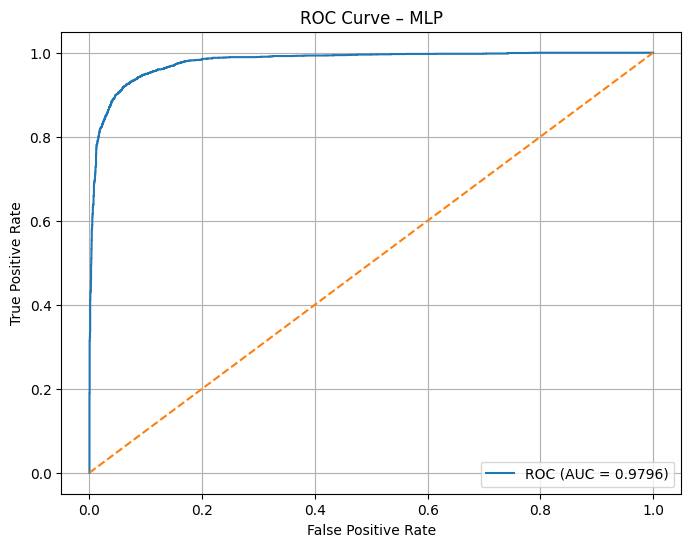


AUC: 0.9796292010460348


In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# identify unique classes
classes = np.unique(y_test)

print("Unique labels:", classes)
print("Number of classes:", len(classes))

# probability scores (P(y=1))
if hasattr(best_model, "predict_proba"):
    y_score = best_model.predict_proba(best_X_test)[:, 1] # positive class only
else:
    y_score = best_model.decision_function(best_X_test)
    # if decision_function returns shape (N,), no slicing needed

print("y_score shape:", y_score.shape)

# compute ROC curve for the positive class
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)

# compute AUC
roc_auc = auc(fpr, tpr)

# plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title(f"ROC Curve – {best_model_name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

print("\nAUC:", roc_auc)
